In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import types as Types
from pyspark.sql import functions as F
from pyspark.sql.functions import col, unix_timestamp, to_date, date_format
import pandas as pd

# Criando a sessão Spark
spark = SparkSession \
        .builder \
        .appName("Getting Start") \
        .getOrCreate()

In [2]:
# Dados obtidos em http://www.portaltransparencia.gov.br/download-de-dados/viagens
# Do ano de 2018

df = spark.read.csv("data/Viagens 2018/2018_Viagem_UTF8.csv", header=True, sep=';')

In [3]:
df.printSchema()

root
 |-- Identificador do processo de viagem: string (nullable = true)
 |-- Situação: string (nullable = true)
 |-- Código do órgão superior: string (nullable = true)
 |-- Nome do órgão superior: string (nullable = true)
 |-- Código órgão solicitante: string (nullable = true)
 |-- Nome órgão solicitante: string (nullable = true)
 |-- CPF viajante: string (nullable = true)
 |-- Nome: string (nullable = true)
 |-- Cargo: string (nullable = true)
 |-- Período - Data de início: string (nullable = true)
 |-- Período - Data de fim: string (nullable = true)
 |-- Destinos: string (nullable = true)
 |-- Motivo: string (nullable = true)
 |-- Valor diárias: string (nullable = true)
 |-- Valor passagens: string (nullable = true)
 |-- Valor outros gastos: string (nullable = true)



In [4]:
df.limit(5).toPandas()

,Identificador do processo de viagem,Situação,Código do órgão superior,Nome do órgão superior,Código órgão solicitante,Nome órgão solicitante,CPF viajante,Nome,Cargo,Período - Data de início,Período - Data de fim,Destinos,Motivo,Valor diárias,Valor passagens,Valor outros gastos
0,0000000000013501576,Realizada,36000,MINISTERIO DA SAUDE,36201,FUNDACAO OSWALDO CRUZ,***.637.54*-**,ELIANE CALDAS DO NASCIMENTO OLIVEIRA,PESQUISADOR EM SAUDE PUBLICA,20180210,20180302,Coimbra/Portugal,PARTICIPAÇÃO EM PROJETOS DE PESQUISA DESENVOLV...,",00",",00",",00"
1,0000000000014026421,Realizada,26000,MINISTERIO DA EDUCACAO,26352,FUNDACAO UNIVERSIDADE FEDERAL DO ABC,***.199.59*-**,ALYSSON FABIO FERRARI,PROFESSOR DO MAGISTERIO SUPERIOR,20180109,20181119,Bloomington - Indiana/Estados Unidos da América,Estágio pós-doutoral no exterior.,",00",",00",",00"
2,0000000000014046485,Realizada,26000,MINISTERIO DA EDUCACAO,26405,"INST.FED.DE EDUC.,CIENC.E TEC.DO CEARA",***.061.02*-**,REGINA LUCIA BEZERRA VASQUES,None,20180223,20180225,Meruoca/CE,Realizar o encontro presencial da Disciplina ...,"537,50","98,68",",00"
3,0000000000014108743,Realizada,26000,MINISTERIO DA EDUCACAO,26258,UNIVERSIDADE TECNOLOGICA FEDERAL DO PARANA,***.414.38*-**,JULIANA BORTOLI RODRIGUES MEES,PROFESSOR ENS BASICO TECN TECNOLOGICO,20180117,20180216,Lisboa/Portugal,"""Estágio/Intercâmbio Internacional no IPPORTO ...",",00",",00",",00"
4,0000000000014112304,Realizada,26000,MINISTERIO DA EDUCACAO,26279,FUNDACAO UNIVERSIDADE FEDERAL DO PIAUI,***.836.65*-**,FRANCISCO DE ASSIS SINIMBU NETO,PROFESSOR ENS BASICO TECN TECNOLOGICO,20180104,20180106,Bom Jesus/PI,o mesmo participará de solenidades de FORMATUR...,"487,11",",00",",00"


In [5]:
# Função usada para converter os dados numericos de String pata Float
def to_value(v):
    try:
        return float(v.replace(',','.'))
    except:
        return 0.0
    
udf_to_value = F.udf(to_value, Types.FloatType())

In [6]:
df_typed = df.withColumn("ValorPassagens", udf_to_value(df["Valor passagens"])) \
  .withColumn("ValorDiarias", udf_to_value(df["Valor diárias"])) \
  .withColumn("ValorOutros", udf_to_value(df["Valor outros gastos"]))

In [7]:
df_typed.select("Nome órgão solicitante", "ValorPassagens").limit(10).toPandas()

,Nome órgão solicitante,ValorPassagens
0,FUNDACAO OSWALDO CRUZ,0.000000
1,FUNDACAO UNIVERSIDADE FEDERAL DO ABC,0.000000
2,"INST.FED.DE EDUC.,CIENC.E TEC.DO CEARA",98.680000
3,UNIVERSIDADE TECNOLOGICA FEDERAL DO PARANA,0.000000
4,FUNDACAO UNIVERSIDADE FEDERAL DO PIAUI,0.000000
5,INST.CHICO MENDES DE CONSER.DA BIODIVERSIDADE,0.000000
6,FUNDACAO OSWALDO CRUZ,0.000000
7,UNIVERSIDADE TECNOLOGICA FEDERAL DO PARANA,1183.469971
8,UNIVERSIDADE TECNOLOGICA FEDERAL DO PARANA,0.000000
9,UNIVERSIDADE FEDERAL DO PARANA,539.750000


In [8]:
# Mais funções veja: https://spark.apache.org/docs/1.6.1/api/java/org/apache/spark/sql/functions.html

df_pandas = df_typed.groupBy("Nome do órgão superior") \
        .agg(F.sum("ValorPassagens").alias("ValorTotal")) \
        .orderBy("ValorTotal", ascending=False) \
        .toPandas()

# Agrupando por Órgão Superior
# Somando todos os valores por órgão
# Ordenando a apresentação por ValorTotal, do valor maior para o menor
# Exibindo com o Pandas

df_pandas

,Nome do órgão superior,ValorTotal
0,MINISTERIO DA EDUCACAO,1.285318e+08
1,MINISTERIO DA DEFESA,5.501473e+07
2,MINISTERIO DA JUSTICA E SEGURANCA PUBLICA,4.895333e+07
3,MINISTERIO DA ECONOMIA,4.548716e+07
4,MINISTERIO DA SAUDE,3.045940e+07
5,MINISTERIO DA INFRAESTRUTURA,1.932596e+07
6,MINISTERIO DAS RELACOES EXTERIORES,1.835539e+07
7,PRESIDENCIA DA REPUBLICA,1.744064e+07
8,MINISTERIO DO MEIO AMBIENTE,1.639831e+07
9,"MINIST. DA AGRICUL.,PECUARIA E ABASTECIMENTO",1.607801e+07


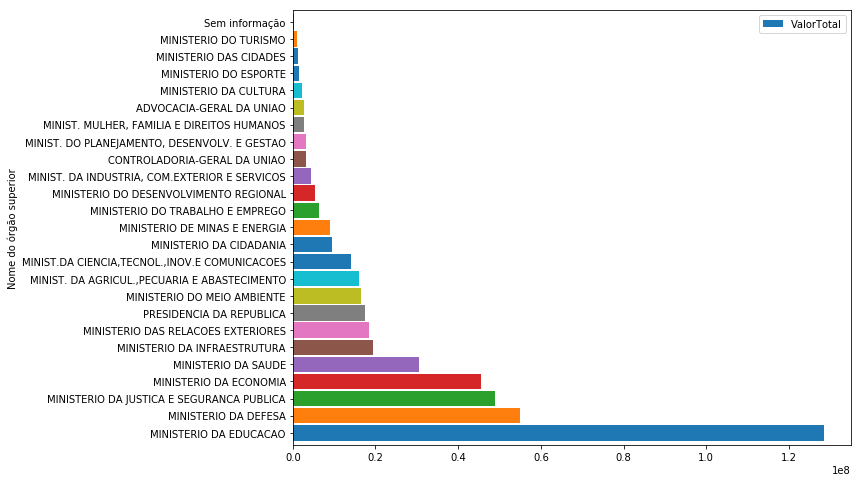

In [9]:
# Mais informações sobre plotagem dos dados com Pandas --> https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

%matplotlib inline
df_pandas.plot(kind="barh", 
               x="Nome do órgão superior", 
               y="ValorTotal", 
               figsize=[10,8], 
               width=0.9)

In [10]:
# Os 10 mais 'gastadores'
df_typed.groupBy("Nome", "CPF viajante") \
       .agg(F.sum("ValorPassagens").alias("ValorTotal")) \
       .orderBy("ValorTotal", ascending=False) \
       .limit(10) \
       .toPandas()

# Para tiramos esse outlier, vamos filtrar na célula abaixo

,Nome,CPF viajante,ValorTotal
0,Informações protegidas por sigilo,***.000.00*-**,4.197474e+07
1,HELTON MOLINA SAPIA,***.917.52*-**,4.393311e+05
2,SERGIO HENRIQUE SA LEITAO FILHO,***.010.85*-**,2.260895e+05
3,MARCOS JORGE DE LIMA,***.678.25*-**,2.177374e+05
4,LEANDRO CRUZ FROES DA SILVA,***.766.50*-**,1.699303e+05
5,CONCEPTA MARGARET MCMANUS PIMENTEL,***.272.88*-**,1.609801e+05
6,ABILIO AFONSO BAETA NEVES,***.419.09*-**,1.599030e+05
7,DECIO FABRICIO ODDONE DA COSTA,***.112.11*-**,1.595598e+05
8,VINICIUS RENE LUMMERTZ SILVA,***.656.69*-**,1.551867e+05
9,EDUARDO REFINETTI GUARDIA,***.666.63*-**,1.466410e+05


In [11]:
# Os 10 mais 'gastadores'
df_typed.groupBy("Nome do órgão superior", "Nome", "CPF viajante") \
       .agg((F.sum("ValorPassagens") + F.sum("ValorDiarias") + F.sum("ValorOutros")).alias("ValorTotal"), \
           F.count("ValorPassagens").alias("QtdPassagens")) \
       .filter("Nome != 'Informações protegidas por sigilo'") \
       .orderBy("ValorTotal", ascending=False) \
       .limit(10) \
       .toPandas()

# Com o método filter(), retiramos o dado "Informações protegidas por sigilo" da lista

,Nome do órgão superior,Nome,CPF viajante,ValorTotal,QtdPassagens
0,MINISTERIO DA EDUCACAO,HELTON MOLINA SAPIA,***.917.52*-**,442218.023804,4
1,MINISTERIO DA CULTURA,SERGIO HENRIQUE SA LEITAO FILHO,***.010.85*-**,325864.210705,50
2,"MINIST. DA INDUSTRIA, COM.EXTERIOR E SERVICOS",MARCOS JORGE DE LIMA,***.678.25*-**,313560.330828,74
3,MINISTERIO DA ECONOMIA,MARCELLO DE MOURA ESTEVAO FILHO,***.488.80*-**,273296.270168,21
4,MINISTERIO DE MINAS E ENERGIA,DECIO FABRICIO ODDONE DA COSTA,***.112.11*-**,272885.018930,48
5,MINISTERIO DA EDUCACAO,CONCEPTA MARGARET MCMANUS PIMENTEL,***.272.88*-**,270564.310410,37
6,MINISTERIO DA ECONOMIA,EDUARDO MANHAES RIBEIRO GOMES,***.088.97*-**,248707.289440,17
7,MINISTERIO DO ESPORTE,LEANDRO CRUZ FROES DA SILVA,***.766.50*-**,235408.701675,78
8,MINISTERIO DA SAUDE,JEAN CARLO DE MIRANDA,***.628.77*-**,232069.540359,12
9,"MINIST. DA INDUSTRIA, COM.EXTERIOR E SERVICOS",ABRAO MIGUEL ARABE NETO,***.757.49*-**,229822.862236,27


In [14]:
# Quanto 'BRENO YUJI PESSOA DE ABREU' gastou em cada mês
pd_gastador = df_typed.filter((df_typed["Nome"] == "MARCOS JORGE DE LIMA") & (df_typed["CPF viajante"] == "***.678.25*-**")) \
        .withColumn("DataPartida", F.to_date(df_typed["Período - Data de início"], format="yyyyMMdd")) \
        .groupBy(F.month("DataPartida").alias("MesPartida")) \
        .agg((F.sum("ValorPassagens") + F.sum("ValorDiarias") + F.sum("ValorOutros")).alias("ValorTotal"), \
           F.count("ValorPassagens").alias("QtdPassagens")) \
        .orderBy("MesPartida") \
        .toPandas()

pd_gastador

,MesPartida,ValorTotal,QtdPassagens
0,1,35251.120422,7
1,2,13040.499844,5
2,3,46903.739803,12
3,4,9831.790100,5
4,5,14657.380585,6
5,6,27721.819939,5
6,7,45309.599976,7
7,8,16373.829956,5
8,9,56028.869751,3
9,10,12057.090210,5


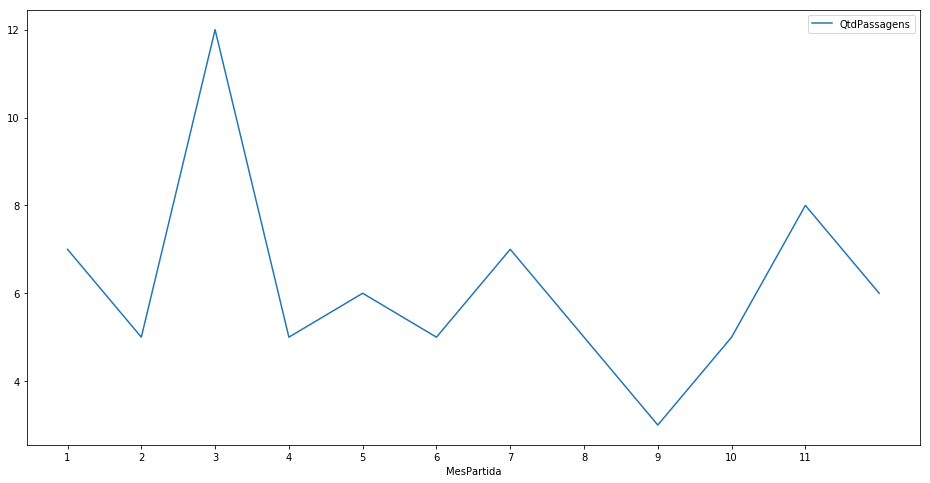

In [27]:
pd_gastador.plot(x="MesPartida",
                 y="QtdPassagens",
                 figsize=[16,8],
                 xticks=range(1,12))